# MAGIC + LST combined analysys: event coincidence search

In [1]:
import yaml
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
import magicctapipe
print(f'magicctapipe version: {magicctapipe.__version__}')

magicctapipe version: 0.3.0


In [2]:
# --- display all columns --- 
pd.set_option('display.max_columns', None)

# --- customize plt figure ---
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 15
plt.rcParams['grid.linestyle'] = ':'

# --- get the default color cycle ---
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

The script for the coincidence search is <b>lst1_magic_event_coincidence.py<b>

This script searches for coincident events from LST-1 and MAGIC joint observation data offline using their timestamps. It applies the coincidence window to LST-1 events, and checks the coincidence within the time offset region specified in the configuration file. Since the optimal time offset changes depending on the telescope distance along the pointing direction, it is recommended to input one subrun file for LST-1 data, whose observation time is usually around 10 seconds so the change of the distance is negligible. The MAGIC standard stereo analysis discards the events when one of the telescope images cannot survive the cleaning or fail to compute the DL1 parameters. However, it's possible to perform the stereo analysis if LST-1 sees these events. Thus, it checks the coincidence for each telescope combination (i.e., LST1 + M1 and LST1 + M2) and keeps the MAGIC events even if they do not have their MAGIC-stereo counterparts. The MAGIC-stereo events, observed during the LST-1 observation time period but not coincident with any LST-1 events, are also saved in the output file, but they are not yet used for the high level analysis. Unless there is any particular reason, please use the default half width 300 ns for the coincidence window, which is optimized to reduce the accidental coincidence rate as much as possible by keeping the number of actual coincident events. Please note that for the data taken before 12th June 2021, a coincidence peak should be found around the time offset of -3.1 us, which can be explained by the trigger time delays of both systems. For the data taken after that date, however, there is an additional global offset appeared and then the peak is shifted to the time offset of -6.5 us. Thus, it would be needed to tune the offset scan region depending on the date when data were taken. The reason of the shift is under investigation.
    

<b>USAGE<b>:

python lst1_magic_event_coincidence.py

--input-file-lst dl1_LST-1.Run03265.0040.h5

--input-dir-magic dl1/MAGIC

(--output-dir dl1_coincidence)

(--config-file config.yaml)


<b>N.B.<b>:


# 1) Input data

FYI: for the date LST (and its directory system) uses the date of the beginning of the observation, whereas MAGIC uses that of the end of the observation.

if you work at the IT container:

In [3]:
#school_data_dir='/fefs/aswg/workspace/2023_joint_analysis_school'

if you work at pic:

In [4]:
#school_data_dir='pnfs/pic.es/data/magic/Users/SWschool2023/data/2023_joint_analysis_school'

Locally:

In [5]:
school_data_dir='/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school'

In [6]:
date_lst='20210213'
date_magic='2021_02_14'

In [7]:
dl1_dir=f'{school_data_dir}/event_coincidence/input/DL1'
lst_dl1_dir=dl1_dir+f'/LST1/{date_lst}'
magic_dl1_dir=dl1_dir+f'/MAGIC/{date_magic}'

In [8]:
#input_file_lst = f'{lst_dl1_dir}/dl1_LST-1.Run03631.0039.h5'
input_file_lst = f'{lst_dl1_dir}/dl1_LST-1.Run03636.0039.h5'

Check LST1 dl1 data

In [9]:
from lstchain.io.io import dl1_params_lstcam_key
from lstchain.reco.utils import add_delta_t_key,get_effective_time
from ctapipe.io import read_table

In [10]:
dl1_lst_data=read_table(input_file_lst, dl1_params_lstcam_key)
dl1_lst_data

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,dragon_time,ucts_time,tib_time,ucts_jump,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,,,,,,,,m,m,m,,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,float64,int64,int64,bool,int64,float64,int64,float64,float64,float64,uint8,uint8,float64,int64
3636,2067001,203.30835914611816,2.308155235285357,-0.9797356306609176,0.059294361761496515,0.981528261092491,3.0811456056011064,0.17518081187994444,0.005537182698284188,0.07903151957140998,0.0029342396201543874,-0.015303092519049735,0.21925482384007544,1.8124883820724962,1.252771667603426,19.395287030997228,0.08449865,0.26922402,0.001078167115902965,0.0026954177897574125,19,0.2032968605666236,0.23680629413804863,0.08563318645664028,1,0.9908932518453828,4.662985675698991,0,1613259416.8394885,0,0,False,-9999,0.45114255792793195,1,50.0,50.0,16.0,1,1,1613259416.8394885,32
3636,2067002,491.8836064338684,2.6918623485728492,0.2557725194602321,0.22048274015382746,0.33768657127101603,0.7114348771038935,0.35146080076931024,0.010117484695825836,0.21892742642009738,0.005747390111104336,0.2014118647638779,-0.09041293015317466,2.6304323297435523,34.82109780442585,14.80559123704517,0.0,0.0,0.0,0.0,48,0.033537715807910984,0.29748594744645673,0.06091527736732531,3,0.9908932456035989,4.66298567986018,0,1613259416.8396316,0,0,False,-9999,0.62290709501853,1,50.0,50.0,16.0,1,1,1613259416.8396316,32
3636,2067003,117.73681449890137,2.0709122813125322,-0.47067992093375,0.6417960535591524,0.7958905467049495,2.2035750329340393,0.08146811391750629,0.004529927995820284,0.04018315282052714,0.0023208194984241514,-0.7920203716207569,-0.4831827973781653,2.4560589655521405,-6.048428966720634,18.992932694861178,0.0,0.0,0.0,0.0,6,0.6874902910752057,0.5390913125176794,0.34445811211213895,1,0.9908932438558996,4.6629856810253125,0,1613259416.8396716,0,0,False,-9999,0.49323779437457155,1,50.0,50.0,16.0,1,1,1613259416.8396716,32
3636,2067004,269.15357875823975,2.4300001587183897,-0.2510406312902176,0.21801048181582688,0.3324905543623156,2.4264975195791396,0.10390980496883048,0.0034819114784493507,0.1011210844648356,0.002950406534365057,0.10508944967259924,-0.4835628001955711,2.208875541832367,-1.7366753908153179,19.76786745643562,0.0,0.0,0.0,0.0,16,0.2370571595659244,0.2370571595659244,0.15679474278069727,1,0.9908932382591,4.662985684756512,0,1613259416.8398,0,0,False,-9999,0.9731621043381671,1,50.0,50.0,16.0,1,1,1613259416.8398,32
3636,2067005,220.9354968070984,2.34426549780427,0.4039424557966808,0.7523042713874102,0.8538918106779075,1.0780350415744073,0.12438091928998507,0.005103860604675248,0.08734264135923833,0.0046701264259688775,-0.7139211336619544,-0.0500092178563878,2.488038649227608,0.889298353522662,22.669219316542694,0.0,0.0,0.0,0.0,19,0.4144954552881819,0.4144954552881819,0.1436256233252963,1,0.9908932239342063,4.662985694306441,0,1613259416.8401282,0,0,False,-9999,0.7022189726352264,1,50.0,50.0,16.0,1,1,1613259416.8401282,32
3636,2067006,151.44720888137817,2.1802612738485667,-0.7047975869465213,-0.8629277523693017,1.1141741086449524,-2.255668497458339,0.1025438110297162,0.004927166459008881,0.043983454190624174,0.0019776411765356464,-0.8008608072792553,0.06433442555490072,2.398607656759421,-2.039425441308481,18.803293138868128,0.556746,1.0,0.0026954177897574125,0.004851752021563342,9,0.5317763321927307,0.20638949198155285,0.20638949198155285,1,0.9908932167249459,4.662985699112615,0,1613

In [11]:
dl1_lst_data =add_delta_t_key(dl1_lst_data)
time=get_effective_time(dl1_lst_data)
print(f'Effective time: {time[0]}\nElapsed time: {time[1]}')

Effective time: 13.585437297821043 s
Elapsed time: 14.002423524856567 s


# 2) Configuration File

In [12]:
config_file = './config_MAGIC_LST.yaml'

with open(config_file, 'rb') as f:
    config = yaml.safe_load(f)

In [13]:
config['event_coincidence']

{'timestamp_type_lst': 'dragon_time',
 'window_half_width': '300 ns',
 'time_offset': {'start': '-10 us', 'stop': '0 us'}}

1) <b> 'timestamp_type_lst'<b> :
- "ucts_time":
   Unified Clock distribution Trigger time Stamping, it's main GPS timestamp information. (Unfortunately sometimes may not be stored)
- "dragon_time":
    The Dragon board has an inner clock counter (133 MHz) that can be used to calculate the relative time with respect to the first run event time (ucts timestamp provided) in case the ucts time information is missing.

  
2) <b>'window_half_width'<b>:

    the algorithm searches for a coincident event in MAGIC dataset, with a timestamp included within half of the coincidence window from LST-1 event timestamp

<img src="coinc_window.png" alt="Alternative text" />


3) <b>'time_offset'<b>:

    to find the final offset value to use for the ocincidence search, the algorithm scan different offset values within a given range (start and stop)


# 3) Running the script

In [14]:
output_dir = f'{school_data_dir}/event_coincidence/output'
# If you are working at the IT container or at pic, create your own directory
#output_dir = './coinc/output'
!mkdir -p $output_dir

Execute script from terminal:

In [15]:
!lst1_magic_event_coincidence\
--input-file-lst $input_file_lst\
--input-dir-magic $magic_dl1_dir\
--output-dir $output_dir\
--config-file $config_file


Input LST-1 DL1 data file: /home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/LST1/20210213/dl1_LST-1.Run03636.0039.h5
LST-1: 48108 events

Input MAGIC directory: /home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14

The following DL1 data files are found:
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M1.Run05094487.001.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M1.Run05094487.002.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M1.Run05094487.003.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M1.Run05094487.004.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincid

/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.003.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.004.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.005.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.006.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.007.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.008.h5
/home/gpirola/Desktop/SoftwareSchool2023/2023_joint_analysis_school/event_coincidence/input/DL1/MAGIC/2021_02_14/dl1_M2.Run05094488.009.h5
/home/gpirola/Desktop/Softw

time offset: -4.9 us --> 0 events
time offset: -4.8 us --> 0 events
time offset: -4.7 us --> 0 events
time offset: -4.6 us --> 0 events
time offset: -4.5 us --> 0 events
time offset: -4.4 us --> 1 events
time offset: -4.3 us --> 3 events
time offset: -4.2 us --> 3 events
time offset: -4.1 us --> 5 events
time offset: -4.0 us --> 5 events
time offset: -3.9 us --> 5 events
time offset: -3.8 us --> 5 events
time offset: -3.7 us --> 4 events
time offset: -3.6 us --> 3 events
time offset: -3.5 us --> 32 events
time offset: -3.4 us --> 167 events
time offset: -3.3 us --> 891 events
time offset: -3.2 us --> 1358 events
time offset: -3.1 us --> 1782 events
time offset: -3.0 us --> 1853 events
time offset: -2.9 us --> 1888 events
time offset: -2.8 us --> 1868 events
time offset: -2.7 us --> 1731 events
time offset: -2.6 us --> 1010 events
time offset: -2.5 us --> 552 events
time offset: -2.4 us --> 128 events
time offset: -2.3 us --> 58 events
time offset: -2.2 us --> 23 events
time offset: -2.

Import function on a notebook:

In [16]:
from magicctapipe.scripts.lst1_magic import event_coincidence

In [17]:
#event_coincidence(input_file_lst=input_file_lst, input_dir_magic=magic_dl1_dir, output_dir=output_dir, config=config)

# 4) Check the output data

The output file contains 3 tables :
1) coincidence

    - feature
    
    it contains:
        - the subrun average timing and pointing information for both MAGIC and LST
        - the average offset, coincidence window and number of found coincident events
    for the  2 'coincidence_id' types
        -12 = M1 - LST
        -13 = M2 - LST
        
    - profile
    
    it contains the number of identified coincident events for the 2 'coincidence_id' types, for all the tried time offsets
    
    
2) configuration/instrument

      it contains a series of camera and instrumental information


3) events:

    - parameters:
    
    it contains all the coincident events information:
        - LST run ID
        - MAGIC run ID
        - the combnation ('combo_type') of telescopes that saw the events:
            - 0 --> M1 + M2 (only)
            - 1 --> LST-1 + M1
            - 2 --> LST-1 + M2
            - 3 --> LST-1 + M1 + M2
        - the multuplicty of the event --> total number of telescopes that saw the event (either 2 or 3)
        - the event single-telescope (Hillas included) parameters for all the telescopes that saw the event
            

In [18]:
tel_combos = {12: "LST1 - M1", 13: "LST1 - M2"}

In [19]:
output_file=f'{output_dir}/dl1_LST-1_MAGIC.Run03636.0039.h5'

# 4.1) Check the coincident event table

In [20]:
data = pd.read_hdf(output_file, key='events/parameters')
data.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data.sort_index(inplace=True)

In [21]:
data.head(10)

obs_id_magic  event_id_magic  obs_id_lst  \
obs_id event_id tel_id                                             
3636   2067002  1            5094488          145606      3636.0   
                2            5094488          145606      3636.0   
                3            5094488          145606      3636.0   
       2067037  1            5094488          145607      3636.0   
                2            5094488          145607      3636.0   
                3            5094488          145607      3636.0   
       2067064  1            5094488          145608      3636.0   
                2            5094488          145608      3636.0   
                3            5094488          145608      3636.0   
       2067075  1            5094488          145609      3636.0   

                        event_id_lst   intensity         x         y  \
obs_id event_id tel_id                                                 
3636   2067002  1          2067002.0  491.883606  0.255773  0.220483   
                2          2067002.0   39.842448 -0.067295  0.092016   
                3          2067002.0   43.039062  0.009772  0.206214   
       2067037  1          2067037.0  568.281787  0.618554  0.318950   
                2          2067037.0  107.148438  0.009816 -0.022747   
                3          2067037.0   83.875000  0.068853  0.182024   
       2067064  1          2067064.0  232.257523  0.400098  0.574464   
                2          2067064.0   59.546875  0.121371  0.071267   
                3          2067064.0   82.820964  0.203027  0.180710   
       2067075  1          2067075.0  242.986968  0.285744  0.173796   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
3636   2067002  1       0.337687   40.762216  0.171758            0.010117   
                2       0.113998  126.179402  0.017189            0.001760   
                3       0.206446   87.287042  0.021737            0.002062   
       2067037  1       0.695944   27.277322  0.169247            0.006161   
                2       0.024775  -66.658194  0.046909            0.001911   
                3       0.194611   69.280175  0.025175            0.002130   
       2067064  1       0.700062   55.143835  0.033250            0.002323   
                2       0.140748   30.420617  0.023691            0.001945   
                3       0.271801   41.671526  0.037134            0.002212   
       2067075  1       0.334447   31.308954  0.068444            0.004586   

                           width  width_uncertainty        psi  skewness  \
obs_id event_id tel_id                                                     
3636   2067002  1       0.106989           0.005747  11.540050 -0.090413   
                2       0.016976           0.001456 -53.941559 -0.664709   
                3       0.010430           0.000756  26.504399  0.360941   
       2067037  1       0.060760           0.003905  36.404510 -0.581237   
                2       0.021984           0.001299  23.094616 -0.513190   
                3       0.016298           0.001103 -81.881885  0.811305   
       2067064  1       0.031969           0.002718  46.856274  0.375004   
                2       0.012446           0.001199   0.134580  0.164114   
                3       0.015635           0.000796 -60.360841 -0.047552   
       2067075  1       0.050084           0.004484  -6.144988  0.325871   

                        kurtosis      slope  intercept  intensity_width_1  \
obs_id event_id tel_id                                                      
3636   2067002  1       2.630432  34.821098  14.805591                0.0   
                2       2.670856 -10.143946  12.991909                0.0   
                3       2.549834  13.730425  15.522098                0.0   
       2067037  1       1.719312  -4.782992  20.183619                0.0   
                2       1.7112

In [22]:
data.columns

Index(['obs_id_magic', 'event_id_magic', 'obs_id_lst', 'event_id_lst',
       'intensity', 'x', 'y', 'r', 'phi', 'length', 'length_uncertainty',
       'width', 'width_uncertainty', 'psi', 'skewness', 'kurtosis', 'slope',
       'intercept', 'intensity_width_1', 'intensity_width_2', 'pixels_width_1',
       'pixels_width_2', 'n_pixels', 'n_islands', 'pointing_alt',
       'pointing_az', 'timestamp', 'time_diff', 'multiplicity', 'combo_type'],
      dtype='object')

You can check the parameters definition the lstcontainer (some names might be different):

https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

<b> Check the intensity correlation between LST-1 and MAGIC <b>

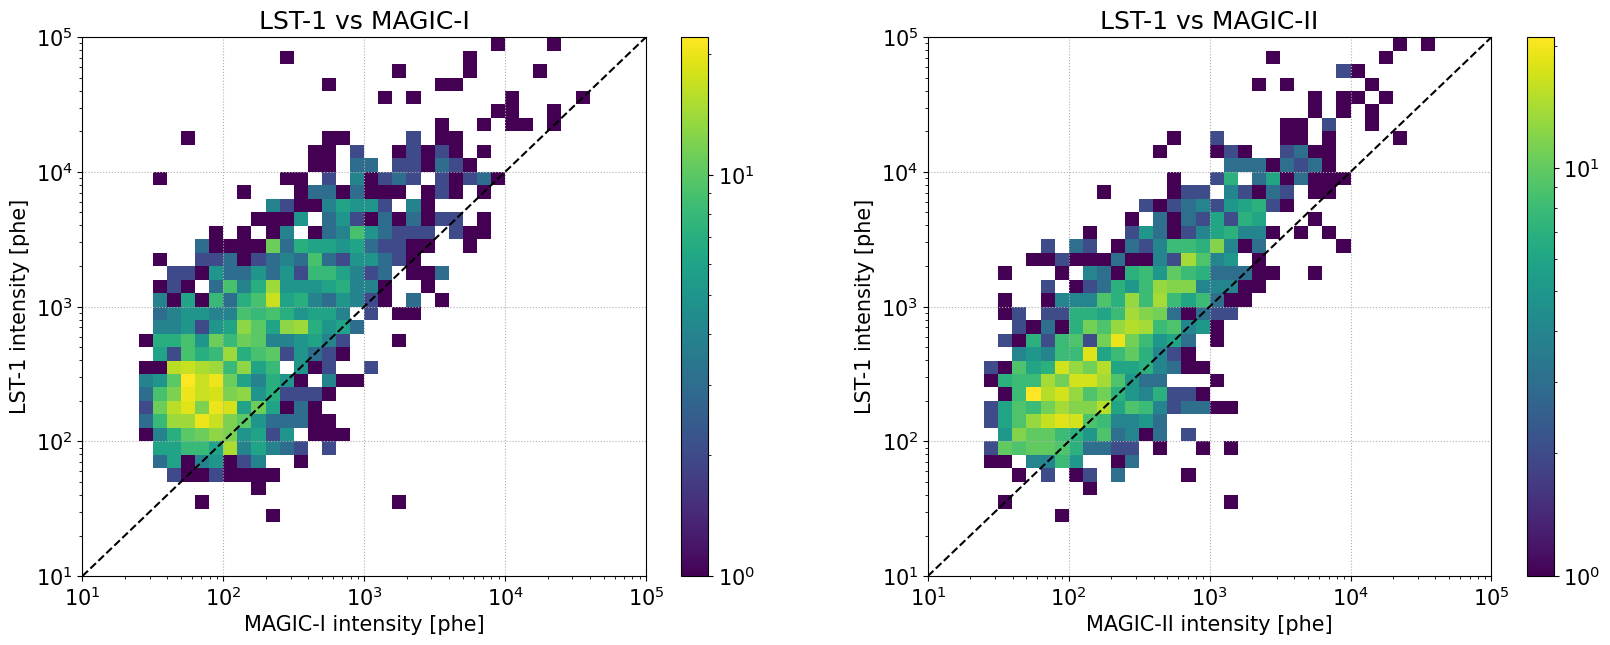

In [23]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

df = data.query('multiplicity == 3')

for i_grid, (tel_name, tel_id) in enumerate(zip(['MAGIC-I', 'MAGIC-II'], [2, 3])):
    
    plt.subplot2grid(grid, (0, i_grid))
    plt.title(f'LST-1 vs {tel_name}')
    plt.xlabel(f'{tel_name} intensity [phe]')
    plt.ylabel('LST-1 intensity [phe]')
    plt.loglog()
    
    plt.hist2d(
        df.query(f'tel_id == {tel_id}')['intensity'].to_numpy(),
        df.query(f'tel_id == 1')['intensity'].to_numpy(),
        bins=np.logspace(1, 5, 41),norm='log'
    )
    
    plt.plot((1e1, 1e5), (1e1, 1e5), linestyle='--', color='black')
    
    plt.colorbar()
    
    plt.grid()

<b> Distribution shifted towards higher values for lst intensity, why? <b>

# 4.2) Check the coincidence distribution

In [24]:
profile = pd.read_hdf(output_file, key='coincidence/profile')
profile

,time_offset,n_coincidence_tel12,n_coincidence_tel13
0,-10.0,3,4
1,-9.9,3,4
2,-9.8,4,3
3,-9.7,4,3
4,-9.6,4,3
...,...,...,...
95,-0.5,5,3
96,-0.4,4,5
97,-0.3,3,6
98,-0.2,3,6


In [25]:
features = pd.read_hdf(output_file, key='coincidence/feature')
features

,coincidence_id,window_half_width,unix_time,pointing_alt_lst,pointing_az_lst,pointing_alt_magic,pointing_az_magic,average_offset,n_coincidence,n_events_magic
0,12,300,1.613259e+09,0.990470,4.663253,0.990415,4.663259,-2.807,1711,2464
1,13,300,1.613259e+09,0.990473,4.663251,0.990434,4.663252,-2.919,1852,2643


/home/gpirola/anaconda3/envs/magic-lst1/lib/python3.8/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/home/gpirola/anaconda3/envs/magic-lst1/lib/python3.8/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


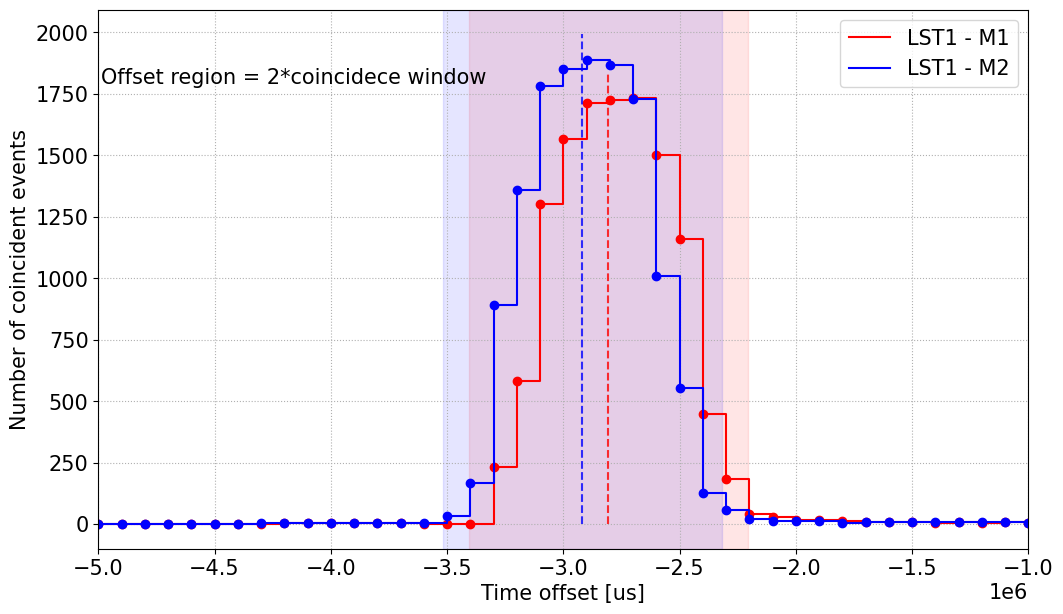

In [26]:
plt.figure(figsize=(12, 7))
plt.xlabel('Time offset [us]')
plt.ylabel('Number of coincident events')
plot_xlim=[-5e6,-1e6]
sec2us = 1e6
ns2us = 1e3
for color,tel_combo in zip(['red','blue'],tel_combos):
    
    combo_name=tel_combos[tel_combo]
    
    plt.plot(
        profile['time_offset'].values * sec2us, profile[f'n_coincidence_tel{tel_combo}'].values, 
        linestyle="None", marker='o', color=color
    )
    
    plt.step(
        profile['time_offset'].values * sec2us, profile[f'n_coincidence_tel{tel_combo}'].values, 
        where='post', label=combo_name,color=color
    )
    
    offset_usec_avg = features.query(f'coincidence_id == {tel_combo}')['average_offset'].values * sec2us
    window_half_width = features.query(f'coincidence_id == {tel_combo}')['window_half_width'].values * ns2us
    
    plt.plot(
        np.repeat(offset_usec_avg, 2), (0, plt.ylim()[1]+10), linestyle='--', alpha=0.8, color=color
    )
    a=plt.ylim()[1]
    plt.axvspan(offset_usec_avg-2*window_half_width,offset_usec_avg+2*window_half_width,alpha=0.1, color=color)
text=f'Offset region = 2*coincidece window'
plt.text(plot_xlim[0]-plot_xlim[0]/500,plt.ylim()[1]-300,s=text,fontsize=15)
plt.grid()
plt.xlim(plot_xlim[0],plot_xlim[1])

plt.legend()

# 5) Run-wise checks

For for file-size reasons, for this part we will load already produced 'dl1_coincidence' sub-run files 

# 5.1) Load all the subrun input files

In [27]:
input_dl1_coinc_dir=f'{dl1_dir}/DL1_coinc'

In [28]:
print("Loading the input files...")

input_files=glob.glob(f'{input_dl1_coinc_dir}/{date_lst}/*3636*.h5')
input_files.sort()
n_files=len(input_files)
data_list=[]
for i_file, input_file in enumerate(input_files):

    if i_file % 10 == 0:
        print(f"{i_file}/{n_files}")

    # Load the coincidence features
    df = pd.read_hdf(input_file, key="coincidence/feature")
    data_list.append(df)

print(f"{n_files}/{n_files}")

# Combine the data frames
features = pd.concat(data_list)

# Show the data frame
features.head()

Loading the input files...
0/86
10/86
20/86
30/86
40/86
50/86
60/86
70/86
80/86
86/86


,coincidence_id,window_half_width,unix_time,pointing_alt_lst,pointing_az_lst,pointing_alt_magic,pointing_az_magic,average_offset,n_coincidence,n_events_magic
0,12,300,1.613259e+09,1.022990,4.642300,1.022957,4.642300,-2.829,116,199
1,13,300,1.613259e+09,1.022990,4.642300,1.023059,4.642336,-2.918,138,312
0,12,300,1.613259e+09,1.022482,4.642632,1.022448,4.642626,-2.823,1609,2511
1,13,300,1.613259e+09,1.022488,4.642628,1.022540,4.642631,-2.936,1799,3230
0,12,300,1.613259e+09,1.021616,4.643207,1.021554,4.643219,-2.827,1617,2395


# 5.2) Check the average offset

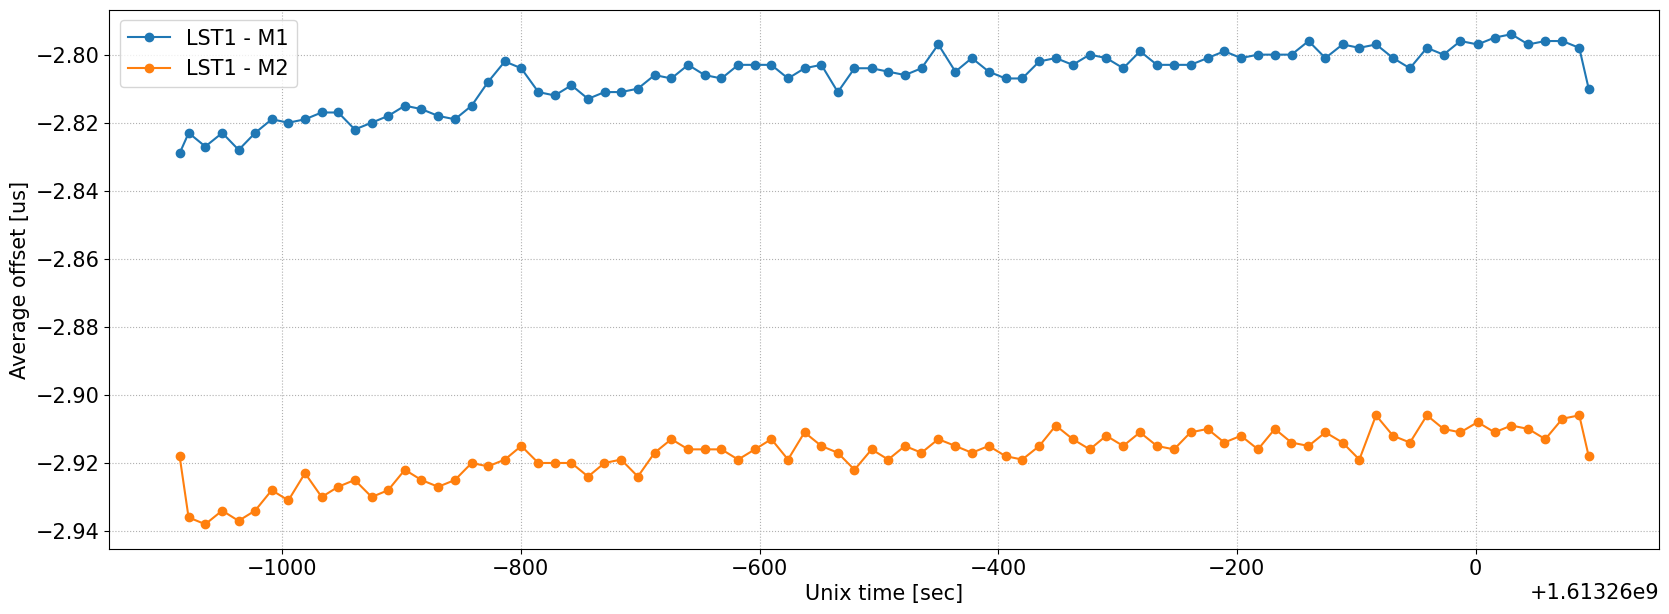

In [29]:
plt.figure(figsize=(20, 7))
plt.xlabel("Unix time [sec]")
plt.ylabel("Average offset [us]")
plt.grid()

# Loop over every coincidence ID
for tel_combo in tel_combos:
    
    combo_name=tel_combos[tel_combo]

    df_features = features.query(f"coincidence_id == {tel_combo}")

    # Plot the average offset
    plt.plot(
        df_features["unix_time"],
        df_features["average_offset"],
        marker="o",
        label=combo_name,
    )

plt.legend()

# 5.2) Check the number of coincident events

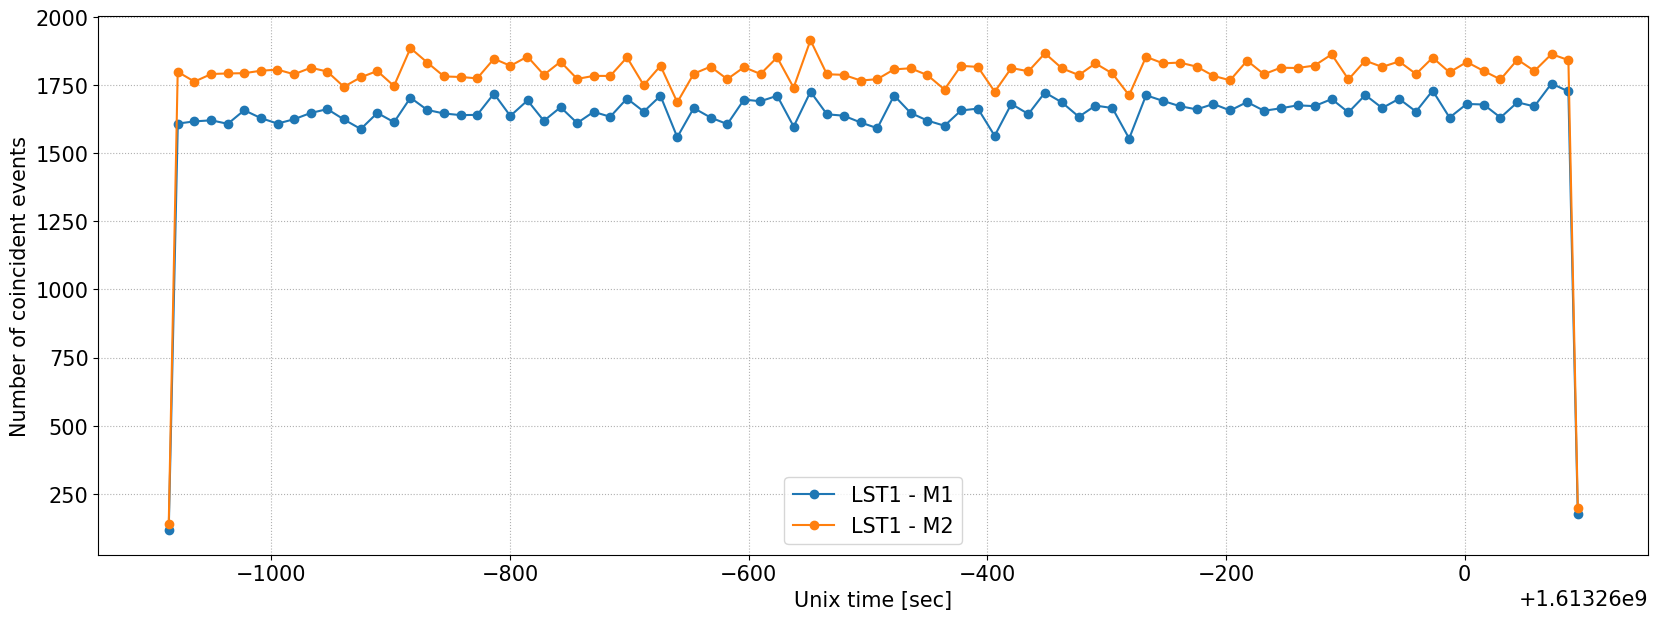

In [30]:
plt.figure(figsize=(20, 7))
plt.xlabel("Unix time [sec]")
plt.ylabel("Number of coincident events")
plt.grid()

# Loop over every coincidence ID
for tel_combo in tel_combos:
    
    combo_name=tel_combos[tel_combo]

    df_features = features.query(f"coincidence_id == {tel_combo}")

    # Plot the number of coincident events
    plt.plot(
        df_features["unix_time"],
        df_features["n_coincidence"],
        marker="o",
        label=combo_name,
    )

plt.legend()

# 5.3) Check the fraction of coincidence

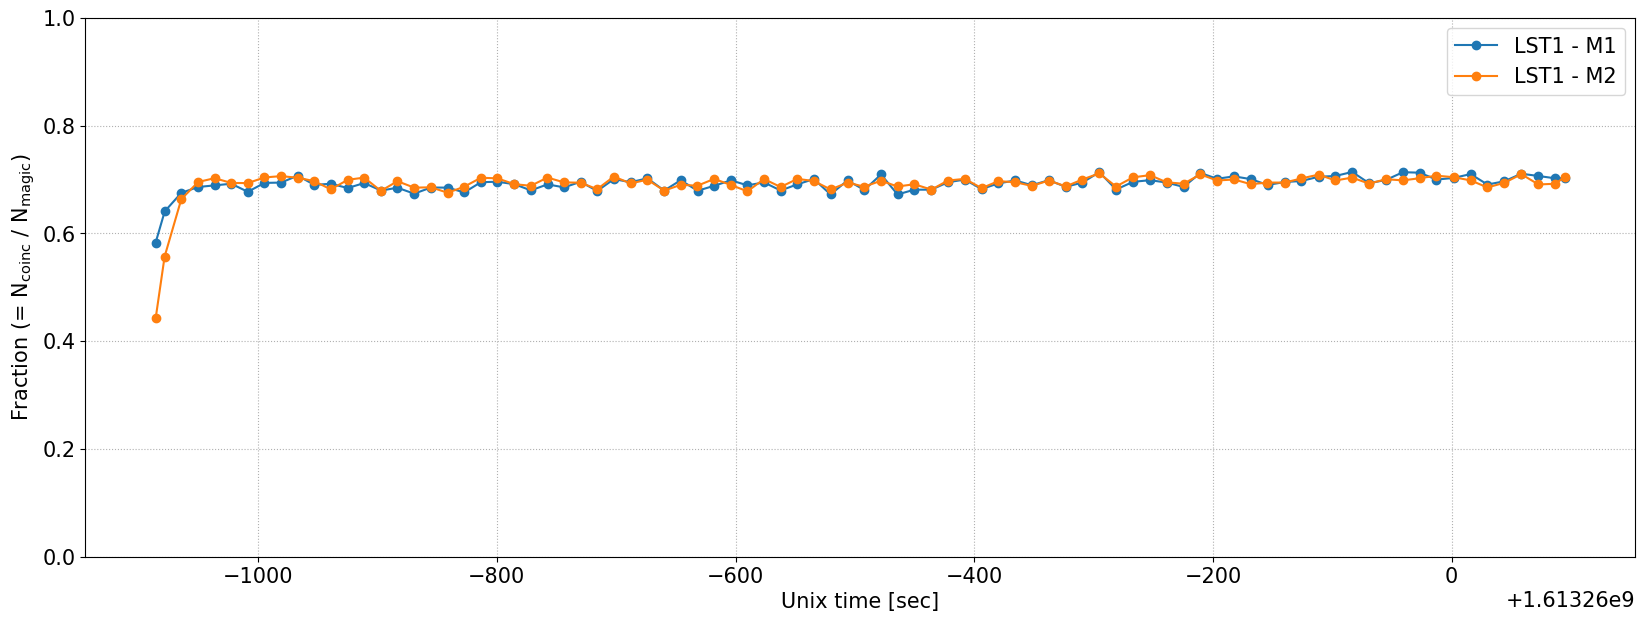

In [31]:
plt.figure(figsize=(20, 7))
plt.xlabel("Unix time [sec]")
plt.ylabel("Fraction (= N$_\mathrm{coinc}$ / N$_\mathrm{magic}$)")
plt.ylim(0, 1)
plt.grid()

# Loop over every coincidence ID
for tel_combo in tel_combos:
    
    combo_name=tel_combos[tel_combo]

    df_features = features.query(f"coincidence_id == {tel_combo}")
    fractions = df_features["n_coincidence"] / df_features["n_events_magic"]

    # Plot the fraction of coincidence
    plt.plot(df_features["unix_time"], fractions, marker="o", label=combo_name)

plt.legend()

# 6) Check cocindences in multiple runs

<b> N.B: For this part the data are not stored in the school directory: no need to download so many files, it's just to show you the plots. <b>
    
<font color='red'> <b> DON'T EXECUTE THE FOLLOWING CELLS <b> </font>

Two main things can be noticed:

    - The drop of coincident events at the end of each run due to the wobble change
    - The change of average time offset, due to the change of source position.

In [32]:
run_list=[3634,3635,3636]
multiple_run_dir=f'{school_data_dir}/event_coincidence/multirun/{date_lst}'

In [33]:
data_list_multiple_runs=[]
for run_number in run_list:
    print(f"Loading the input files for run {run_number}...")
    input_files=glob.glob(f'{multiple_run_dir}/*{run_number}*.h5')
    input_files.sort()
    n_files=len(input_files)

    for i_file, input_file in enumerate(input_files):

        if i_file % 10 == 0:
            print(f"{i_file}/{n_files}")

        # Load the coincidence features
        df = pd.read_hdf(input_file, key="coincidence/feature")
        df['run_number']=run_number
        data_list_multiple_runs.append(df)
    
    print(f"{n_files}/{n_files}")

# Combine the data frames
features_multiple_runs = pd.concat(data_list_multiple_runs)
features_multiple_runs=features_multiple_runs.set_index('run_number')
# Show the data frame
features_multiple_runs.head()

Loading the input files for run 3634...
0/81
10/81
20/81
30/81
40/81
50/81
60/81
70/81
80/81
81/81
Loading the input files for run 3635...
0/74
10/74
20/74
30/74
40/74
50/74
60/74
70/74
74/74
Loading the input files for run 3636...
0/86
10/86
20/86
30/86
40/86
50/86
60/86
70/86
80/86
86/86


,coincidence_id,window_half_width,unix_time,pointing_alt_lst,pointing_az_lst,pointing_alt_magic,pointing_az_magic,average_offset,n_coincidence,n_events_magic
run_number,,,,,,,,,,
3634,12,300,1.613257e+09,1.172179,4.521167,1.172118,4.521289,-2.897,1506,2321
3634,13,300,1.613257e+09,1.172184,4.521162,1.172141,4.521308,-2.990,1665,2543
3634,12,300,1.613257e+09,1.171314,4.522043,1.171287,4.522150,-2.903,1551,2342
3634,13,300,1.613257e+09,1.171314,4.522043,1.171161,4.522143,-2.994,1712,2528
3634,12,300,1.613257e+09,1.170515,4.522851,1.170457,4.522993,-2.901,1479,2206


/tmp/ipykernel_35403/3117332777.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot2grid(grid, (i_grid,0))


NameError: name 'features_2runs' is not defined

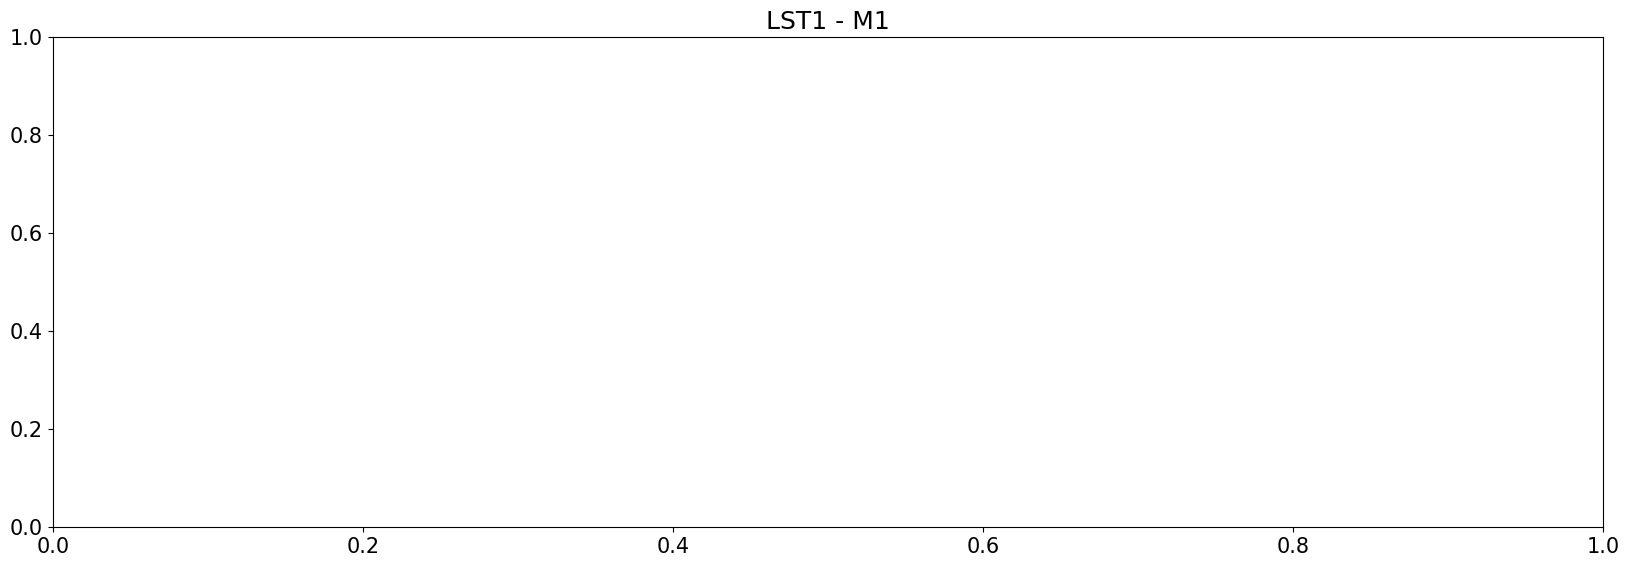

In [34]:
plt.figure(figsize=(20, 14))
plt.xlabel("Unix time [sec]")
plt.ylabel("Average offset [us]")
grid = (2, 1)

for i_grid,tel_combo in enumerate(tel_combos):
    ax = plt.gca()
    combo_name=tel_combos[tel_combo]
    plt.subplot2grid(grid, (i_grid,0))
    
    
    plt.title(f'{combo_name}')
    for run_number in run_list:
        color = next(ax._get_lines.prop_cycler)['color']
        features_run=features_multiple_runs.iloc[features_2runs.index.get_level_values('run_number') == run_number]
        df_features = features_run.query(f"coincidence_id == {tel_combo}")
        
        plt.plot(
            df_features["unix_time"],
            df_features["average_offset"],
            marker="o",
            label=run_number,
        )
    plt.ylabel("Average offset [us]")
    plt.xlabel("Unix time [sec]")
    plt.grid()
    plt.legend()

In [ ]:
plt.figure(figsize=(20, 14))

plt.xlabel("Unix time [sec]")
plt.ylabel("Number of coincident events")

# Loop over every coincidence ID
grid = (2, 1)

for i_grid,tel_combo in enumerate(tel_combos):
    ax = plt.gca()
    combo_name=tel_combos[tel_combo]
    plt.subplot2grid(grid, (i_grid,0))
    
    
    plt.title(f'{combo_name}')
    for run_number in run_list:
        color = next(ax._get_lines.prop_cycler)['color']
        features_run=features_multiple_runs.iloc[features_2runs.index.get_level_values('run_number') == run_number]
        df_features = features_run.query(f"coincidence_id == {tel_combo}")
        
        # Plot the number of coincident events
        plt.plot(
            df_features["unix_time"],
            df_features["n_coincidence"],
            marker="o",
            label=run_number,
            color=color
        )
    plt.xlabel("Unix time [sec]")
    plt.ylabel("Number of coincident events")
    plt.grid()
    plt.legend()

In [ ]:
plt.figure(figsize=(20, 14))


grid = (2, 1)

for i_grid,tel_combo in enumerate(tel_combos):
    ax = plt.gca()
    combo_name=tel_combos[tel_combo]
    plt.subplot2grid(grid, (i_grid,0))
    
    
    plt.title(f'{combo_name}')
    for run_number in run_list:
        color = next(ax._get_lines.prop_cycler)['color']
        features_run=features_multiple_runs.iloc[features_2runs.index.get_level_values('run_number') == run_number]
        df_features = features_run.query(f"coincidence_id == {tel_combo}")
        
        fractions = df_features["n_coincidence"] / df_features["n_events_magic"]

    # Plot the fraction of coincidence
        plt.plot(df_features["unix_time"], fractions, marker="o", label=run_number)
    plt.xlabel("Unix time [sec]")
    plt.ylabel("Fraction (= N$_\mathrm{coinc}$ / N$_\mathrm{magic}$)")
    plt.grid()
    plt.legend()

In [ ]:
k=0
plt.figure(figsize=(21, 12))
colors=['red','blue','green']
for tel_combo in (tel_combos):
    
    combo_name=tel_combos[tel_combo]
    
    for j,run_number in enumerate(run_list):
        color=colors[j]
        features_run=features_multiple_runs.iloc[features_2runs.index.get_level_values('run_number') == run_number]
        df_features = features_run.query(f"coincidence_id == {tel_combo}")
        a=231+k
        
        plt.subplot(a)
        plt.title(f'{combo_name}')
        plt.plot(
            df_features["unix_time"],
            np.rad2deg(df_features["pointing_alt_lst"]),
            marker="",
            label=run_number,
            color=color

        )
        plt.plot(
            df_features["unix_time"],
            np.rad2deg(df_features["pointing_alt_magic"]),
            marker="o",
            markersize=20,
            color=color,
            alpha=0.01
        )
        plt.xlabel("Unix time [sec]")
        plt.ylabel("Altitude [deg] ")
        plt.grid()
        plt.legend()
        
        
        plt.subplot(a+1)
        plt.title(f'{combo_name}')
        plt.plot(
            df_features["unix_time"],
            np.rad2deg(df_features["pointing_az_lst"]),
            marker="",
            color=color,
            label=run_number,
    
        )
        plt.plot(
            df_features["unix_time"],
            np.rad2deg(df_features["pointing_az_magic"]),
            marker="o",
            markersize=20,
            color=color,
            alpha=0.01
        )
        plt.xlabel("Unix time [sec]")
        plt.ylabel("Altitude [deg] ")
        plt.grid()
        plt.legend()
        
        
        plt.subplot(a+2)
        plt.title(f'{combo_name}')
        plt.plot(
            np.rad2deg(df_features["pointing_az_lst"]),
            np.rad2deg(df_features["pointing_alt_lst"]),
            marker="",
            label=run_number,
            color=color
        )
        plt.plot(
            np.rad2deg(df_features["pointing_az_magic"]),
            np.rad2deg(df_features["pointing_alt_magic"]),
            marker="o",
            markersize=20,
            color=color,
            alpha=0.01
        )
        plt.xlabel("Azimuth [deg] ")
        plt.ylabel("Altitude [deg] ")
        plt.grid()
        plt.legend()
    k=3

In [ ]:
!rm -r $output_dir